In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt 
from utils import *
from kernel_sca_inducing_points import *
from kernels import *
import plotly.graph_objs as go
import plotly.express as px 

In [2]:

directory_path = '/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/So and Shadlen 2022/PSTHs'

files = [f for f in os.listdir(directory_path) if 'DotsOn_Leader' in f]

PSTHs = []
for file in files:
    try:
        mat_data = scipy.io.loadmat(f'{directory_path}/{file}')    
        PSTHs.append(np.vstack(mat_data['DotsOn'].squeeze()))
    except Exception as e:
        print(f"Error processing {file}: {e}")

PSTHs = np.stack(PSTHs)
ids = [ 0, 1, 2, 3, 4, -5, -4, -3, -2, -1]
print(PSTHs.shape)
PSTHs = PSTHs[:,ids,:] #2:-5

Error processing DotsOn_Leader_1_22.mat: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 26 and the array at index 5 has size 1
(89, 12, 26)


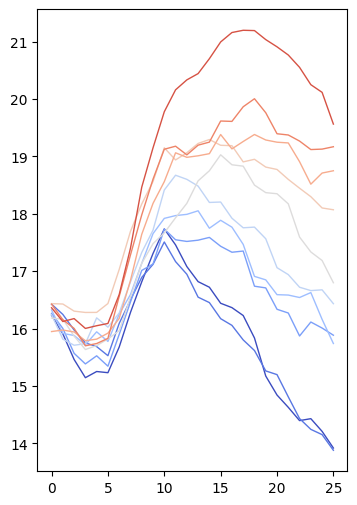

In [3]:
test = np.mean(PSTHs, axis=0)
K, T = test.shape

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
cmap = plt.cm.coolwarm
for k in range(K):
    x = test[k, :]
    color = cmap(k / K)
    ax.plot(x, linestyle='-', linewidth=1, color=color) #marker='.'


In [4]:
X = PSTHs.swapaxes(0,1)
X, _ = pre_processing(X, soft_normalize='max', center=False, pca=False) #pca=False

K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)               
A = A.reshape(N,-1)  



In [54]:
d = 3
c = 40
kernel_function = K_X_Y_squared_exponential

wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=300, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

Iteration 0, S: 0.16529931128025055, S_ratio: 0.3292750120162964
Iteration 10, S: 2.8131299018859863, S_ratio: 0.31478050351142883
Iteration 20, S: 8.9135103225708, S_ratio: 0.2770470380783081
Iteration 30, S: 10.896108627319336, S_ratio: 0.2833919823169708
Iteration 40, S: 21.668968200683594, S_ratio: 0.2913302481174469
Iteration 50, S: 25.131452560424805, S_ratio: 0.29975858330726624
Iteration 60, S: 27.74102783203125, S_ratio: 0.30876269936561584
Iteration 70, S: 23.367631912231445, S_ratio: 0.3129905164241791
Iteration 80, S: 26.35995864868164, S_ratio: 0.3131123185157776
Iteration 90, S: 20.454042434692383, S_ratio: 0.3146480321884155
Iteration 100, S: 20.010337829589844, S_ratio: 0.31325191259384155
Iteration 110, S: 22.55816650390625, S_ratio: 0.3138231337070465
Iteration 120, S: 21.663257598876953, S_ratio: 0.31672537326812744
Iteration 130, S: 26.44091796875, S_ratio: 0.31531795859336853
Iteration 140, S: 24.51358413696289, S_ratio: 0.31457778811454773
Iteration 150, S: 24.673

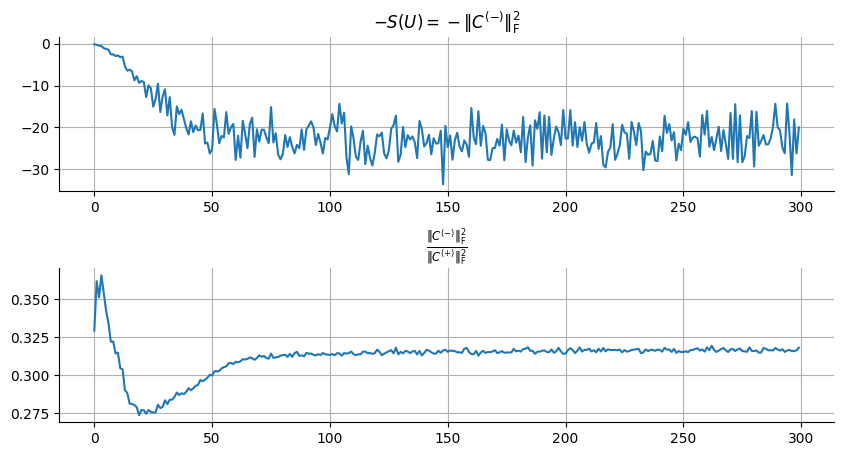

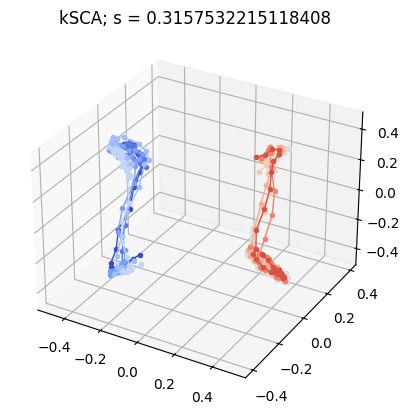

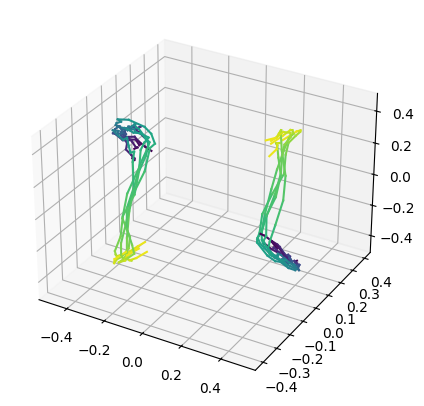

In [55]:
get_loss_fig(ls_loss, ls_S_ratio)

_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u, H_K_A_u, alpha= get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = plt.cm.coolwarm
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :] 
    color = cmap(k / K)
    ax.plot(x, y, z, linestyle='-', marker='.', linewidth=1, color=color)
    #ax.plot(x, y, linestyle='-', marker='.', linewidth=1, color=color)

plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

plot_3D(Y[:,:,:])

Iteration 0, S: 0.41480931639671326, S_ratio: 0.23480010032653809
Iteration 10, S: 0.8558412790298462, S_ratio: 0.21717649698257446
Iteration 20, S: 1.3491110801696777, S_ratio: 0.21586771309375763
Iteration 30, S: 3.0379433631896973, S_ratio: 0.20494578778743744
Iteration 40, S: 4.5279364585876465, S_ratio: 0.1997048407793045
Iteration 50, S: 9.863710403442383, S_ratio: 0.19279873371124268
Iteration 60, S: 11.477950096130371, S_ratio: 0.18920999765396118
Iteration 70, S: 19.881336212158203, S_ratio: 0.1833961308002472
Iteration 80, S: 18.105133056640625, S_ratio: 0.18870475888252258
Iteration 90, S: 23.333208084106445, S_ratio: 0.19645822048187256
Iteration 100, S: 27.39165496826172, S_ratio: 0.20622135698795319
Iteration 110, S: 19.62797737121582, S_ratio: 0.21048083901405334
Iteration 120, S: 31.704256057739258, S_ratio: 0.21860040724277496
Iteration 130, S: 39.37071228027344, S_ratio: 0.23028045892715454
Iteration 140, S: 26.99679946899414, S_ratio: 0.22439803183078766
Iteration 15

Text(0.5, 0.92, 'SCA; s = 0.2330201417207718')

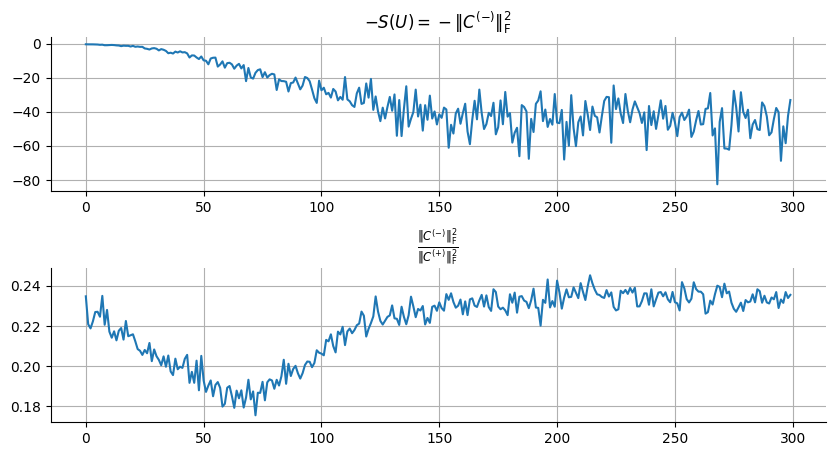

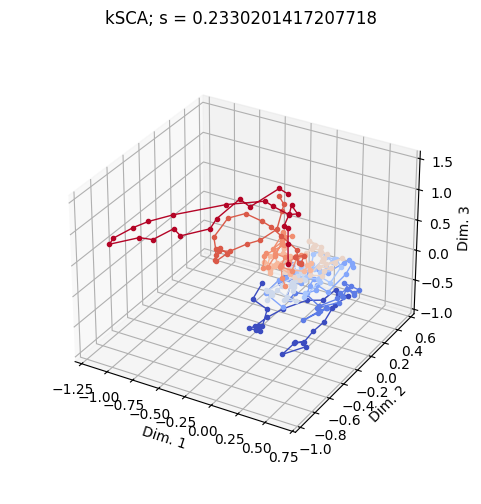

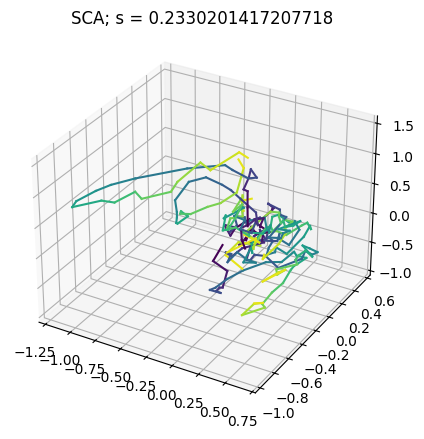

In [6]:
from linear_sca import *
d=3
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(center(X), d=d, learning_rate=0.01, iterations=300) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, center(X))

    
plot_3D_K_coded(Y)

plot_3D(Y[:,:,:])
plt.title(f'SCA; s = {compute_S_all_pairs(Y)}')

ENDS HERE 

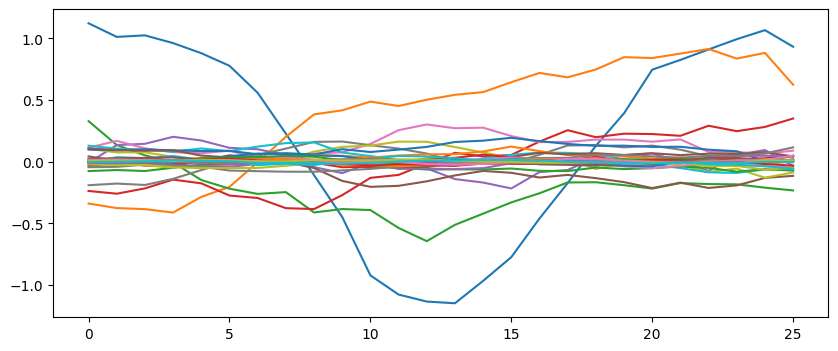

In [40]:
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.plot( X[-1,i,:] )

In [58]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()